# Performance of the Variational Quantum Algorithms in the Presense of Noise

In this notebook, we will investigate the performance of the VQAs in solving the MIS problem in the presence of noise. To incorporate noise, we import the noise parameters of the actual backends and simulate the noisy backend using AerSimulator. In particular, we will use the noise parameters of __ibm_torino__ backend.

### Importing required functions

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from qiskit import *
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import BackendEstimatorV2 as Estimator

import rustworkx as rx
import numpy as np
from rustworkx.visualization import mpl_draw
import matplotlib.pyplot as plt

from src.graph_gen import *
from src.hamiltonian_gen import get_hamiltonian_from_graph
from src.helper_functions import top_k_counts

In [3]:
from src.bfminimize import BFMinimizeCombinatorial
from src.qaoa import QAOA
from src.adaptqaoa import AdaptQAOA
from src.vqe import VQE
from src.dcqaoa import DCQAOA

#### Graph Generation and Brute Force Optimization

In [4]:
num_instances = 10
graph_instances = []
graph_hamiltonians = []

for i in range(num_instances):
    graph = generate_random_graph(6, 0.4)
    graph_instances.append(graph)
    cost_hamiltonian = get_hamiltonian_from_graph(graph)
    graph_hamiltonians.append(cost_hamiltonian)

In [5]:
brute_optimal_cost = []
for hamiltonian in graph_hamiltonians:
    brute = BFMinimizeCombinatorial(hamiltonian)
    brute.run()
    brute_optimal_cost.append(brute.optimal_value)

avg_brute_optimal_cost = sum(brute_optimal_cost)/num_instances

#### Importing the noise parameters of 'ibm_torino' backend

In [6]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
torino_backend = service.backend('ibm_torino')

noisy_backend = AerSimulator.from_backend(torino_backend)
noiseless_backend = AerSimulator()

estimator = Estimator(backend = noisy_backend)
pm = generate_preset_pass_manager(backend = noisy_backend)

#### VQE

In [7]:
max_repetitions = 5
repetitions_list = range(1, max_repetitions + 1)

In [8]:
vqe_noiseless_optimal_cost = []
optimal_ansatz_vqe = []

for reps in repetitions_list:
    print(f"Solving for Reps {reps}...")
    optimal_ansatz_vqe.append([])
    vqe_noiseless_optimal_cost.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        vqe_ansatz = TwoLocal(
                hamiltonian.num_qubits,
                rotation_blocks = ['rx'],
                entanglement_blocks = ['cz'],
                entanglement = 'full',
                reps = reps,
            )
        vqe = VQE(hamiltonian, ansatz = vqe_ansatz)
        vqe.run()
        vqe_noiseless_optimal_cost[-1].append(vqe.optimal_value)
        optimal_ansatz_vqe[-1].append(vqe.ansatz.copy().assign_parameters(vqe.optimal_parameters))

Solving for Reps 1...
Solving for Reps 2...
Solving for Reps 3...
Solving for Reps 4...
Solving for Reps 5...


In [9]:
avg_vqe_noiseless_optimal_cost = []
for optimal_cost_arr in vqe_noiseless_optimal_cost:
    avg_vqe_noiseless_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_vqe_error_noiseless = [np.abs(avg_brute_optimal_cost - v_opt) for v_opt in avg_vqe_noiseless_optimal_cost]

In [10]:
vqe_noisy_optimal_cost = []

for ansatz_arr in optimal_ansatz_vqe:
    vqe_noisy_optimal_cost.append([])
    for ansatz, hamiltonian in zip(ansatz_arr, graph_hamiltonians):
        transpiled_ansatz = pm.run(ansatz)
        mapped_hamiltonian = hamiltonian.apply_layout(layout = transpiled_ansatz.layout)
        cost = estimator.run([(transpiled_ansatz, mapped_hamiltonian)]).result()[0].data.evs
        vqe_noisy_optimal_cost[-1].append(cost)

In [11]:
avg_vqe_noisy_optimal_cost = []
for optimal_cost_arr in vqe_noisy_optimal_cost:
    avg_vqe_noisy_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_vqe_error_noisy = [np.abs(avg_brute_optimal_cost - v_opt) for v_opt in avg_vqe_noisy_optimal_cost]

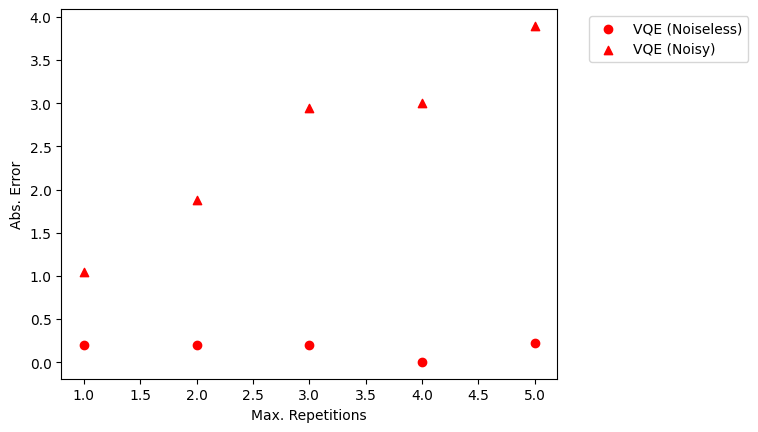

In [44]:
plt.scatter(repetitions_list, avg_vqe_error_noiseless, color = 'r', marker = 'o', label = 'VQE (Noiseless)')
plt.scatter(repetitions_list, avg_vqe_error_noisy, color = 'r', marker = '^', label = 'VQE (Noisy)')

plt.xlabel("Max. Repetitions")
plt.ylabel("Abs. Error")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

There are two main, but obvious, findings. First, we can notice that the results from the noisy simulations are worse than the noiseless simulations, which is expected. Next, the results from the noisy simulations get worse as the number of layers increases. This is another expected effect, as noise is expected to be worse in longer circuits than shorter ones.

Next, we figure out the effect of noise in the other variational algorithms.

#### QAOA

In [13]:
qaoa_noiseless_optimal_cost = []
optimal_ansatz_qaoa = []

for reps in repetitions_list:
    print(f"Solving for Reps {reps}...")
    qaoa_noiseless_optimal_cost.append([])
    optimal_ansatz_qaoa.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        qaoa = QAOA(hamiltonian, num_layers = reps)
        qaoa.run()
        qaoa_noiseless_optimal_cost[-1].append(qaoa.optimal_value)
        optimal_ansatz_qaoa[-1].append(qaoa.ansatz.copy().assign_parameters(qaoa.optimal_parameters))

Solving for Reps 1...
Solving for Reps 2...
Solving for Reps 3...
Solving for Reps 4...
Solving for Reps 5...


In [14]:
avg_qaoa_noiseless_optimal_cost = []
for optimal_cost_arr in qaoa_noiseless_optimal_cost:
    avg_qaoa_noiseless_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_qaoa_error_noiseless = [np.abs(avg_brute_optimal_cost - q_opt) for q_opt in avg_qaoa_noiseless_optimal_cost]

In [15]:
qaoa_noisy_optimal_cost = []

for ansatz_arr in optimal_ansatz_qaoa:
    qaoa_noisy_optimal_cost.append([])
    for ansatz, hamiltonian in zip(ansatz_arr, graph_hamiltonians):
        transpiled_ansatz = pm.run(ansatz)
        mapped_hamiltonian = hamiltonian.apply_layout(layout = transpiled_ansatz.layout)
        cost = estimator.run([(transpiled_ansatz, mapped_hamiltonian)]).result()[0].data.evs
        qaoa_noisy_optimal_cost[-1].append(cost)

In [16]:
avg_qaoa_noisy_optimal_cost = []
for optimal_cost_arr in qaoa_noisy_optimal_cost:
    avg_qaoa_noisy_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_qaoa_error_noisy = [np.abs(avg_brute_optimal_cost - q_opt) for q_opt in avg_qaoa_noisy_optimal_cost]

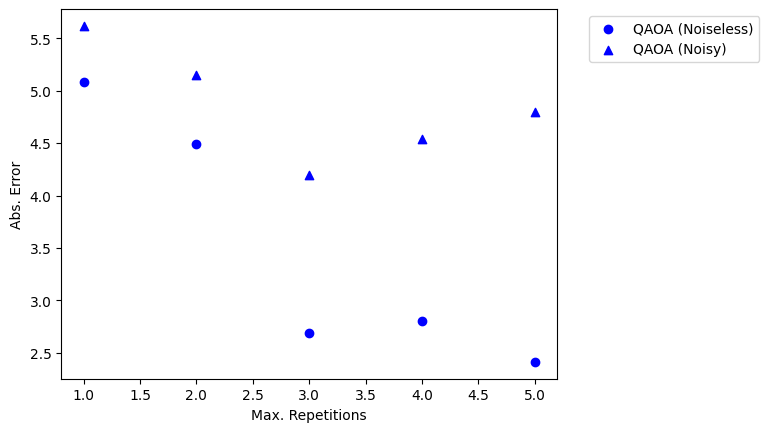

In [45]:
plt.scatter(repetitions_list, avg_qaoa_error_noiseless, color = 'b', marker = 'o', label = 'QAOA (Noiseless)')
plt.scatter(repetitions_list, avg_qaoa_error_noisy, color = 'b', marker = '^', label = 'QAOA (Noisy)')

plt.xlabel("Max. Repetitions")
plt.ylabel("Abs. Error")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### ADAPT-QAOA

In [18]:
aqaoa_single_noiseless_optimal_cost = []
optimal_ansatz_aqaoa_single = []

for reps in repetitions_list:
    print(f"Solving for Reps {reps}...")
    aqaoa_single_noiseless_optimal_cost.append([])
    optimal_ansatz_aqaoa_single.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        adapt_qaoa_single = AdaptQAOA(hamiltonian, max_num_layers = reps, mixer_pool_type = 'single')
        adapt_qaoa_single.run()
        aqaoa_single_noiseless_optimal_cost[-1].append(adapt_qaoa_single.optimal_value)
        optimal_ansatz_aqaoa_single[-1].append(adapt_qaoa_single.optimal_ansatz.copy().assign_parameters(adapt_qaoa_single.optimal_parameters))

Solving for Reps 1...
Solving for Reps 2...
Solving for Reps 3...
Solving for Reps 4...
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.
Solving for Reps 5...
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.


In [19]:
avg_aqaoa_single_noiseless_optimal_cost = []
for optimal_cost_arr in aqaoa_single_noiseless_optimal_cost:
    avg_aqaoa_single_noiseless_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_aqaoa_single_error_noiseless = [np.abs(avg_brute_optimal_cost - aq_opt) for aq_opt in avg_aqaoa_single_noiseless_optimal_cost]

In [20]:
aqaoa_single_noisy_optimal_cost = []

for ansatz_arr in optimal_ansatz_aqaoa_single:
    aqaoa_single_noisy_optimal_cost.append([])
    for ansatz, hamiltonian in zip(ansatz_arr, graph_hamiltonians):
        transpiled_ansatz = pm.run(ansatz)
        mapped_hamiltonian = hamiltonian.apply_layout(layout = transpiled_ansatz.layout)
        cost = estimator.run([(transpiled_ansatz, mapped_hamiltonian)]).result()[0].data.evs
        aqaoa_single_noisy_optimal_cost[-1].append(cost)

In [21]:
avg_aqaoa_single_noisy_optimal_cost = []
for optimal_cost_arr in aqaoa_single_noisy_optimal_cost:
    avg_aqaoa_single_noisy_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_aqaoa_single_error_noisy = [np.abs(avg_brute_optimal_cost - q_opt) for q_opt in avg_aqaoa_single_noisy_optimal_cost]

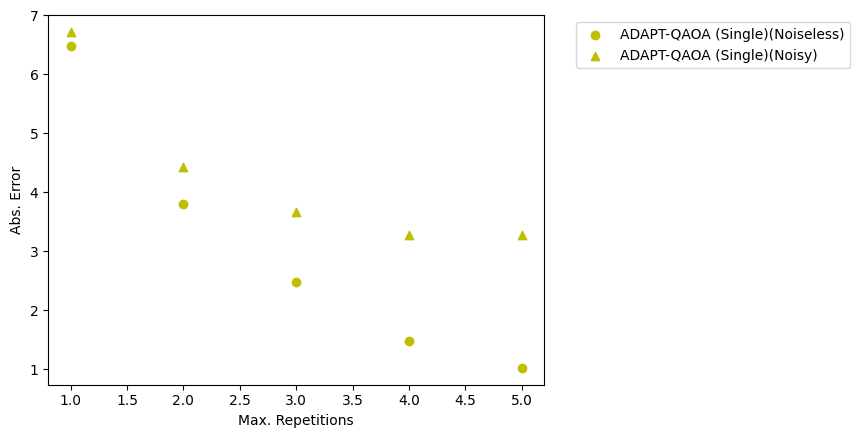

In [46]:
plt.scatter(repetitions_list, avg_aqaoa_single_error_noiseless, color = 'y', marker = 'o', label = 'ADAPT-QAOA (Single)(Noiseless)')
plt.scatter(repetitions_list, avg_aqaoa_single_error_noisy, color = 'y', marker = '^', label = 'ADAPT-QAOA (Single)(Noisy)')

plt.xlabel("Max. Repetitions")
plt.ylabel("Abs. Error")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [23]:
aqaoa_double_noiseless_optimal_cost = []
optimal_ansatz_aqaoa_double = []

for reps in repetitions_list:
    print(f"Solving for Reps {reps}...")
    aqaoa_double_noiseless_optimal_cost.append([])
    optimal_ansatz_aqaoa_double.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        adapt_qaoa_double = AdaptQAOA( hamiltonian, max_num_layers = reps, mixer_pool_type = 'double')
        adapt_qaoa_double.run()
        aqaoa_double_noiseless_optimal_cost[-1].append(adapt_qaoa_double.optimal_value)
        optimal_ansatz_aqaoa_double[-1].append(adapt_qaoa_double.optimal_ansatz.copy().assign_parameters(adapt_qaoa_double.optimal_parameters))

Solving for Reps 1...
Solving for Reps 2...
Solving for Reps 3...
Solving for Reps 4...
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.
Solving for Reps 5...
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.
The difference in the cost of two consecutive iterations is less than the error threshold. The algorithm has converged.


In [24]:
avg_aqaoa_double_noiseless_optimal_cost = []
for optimal_cost_arr in aqaoa_double_noiseless_optimal_cost:
    avg_aqaoa_double_noiseless_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_aqaoa_double_error_noiseless = [np.abs(avg_brute_optimal_cost - aq_opt) for aq_opt in avg_aqaoa_double_noiseless_optimal_cost]

In [25]:
aqaoa_double_noisy_optimal_cost = []

for ansatz_arr in optimal_ansatz_aqaoa_double:
    aqaoa_double_noisy_optimal_cost.append([])
    for ansatz, hamiltonian in zip(ansatz_arr, graph_hamiltonians):
        transpiled_ansatz = pm.run(ansatz)
        mapped_hamiltonian = hamiltonian.apply_layout(layout = transpiled_ansatz.layout)
        cost = estimator.run([(transpiled_ansatz, mapped_hamiltonian)]).result()[0].data.evs
        aqaoa_double_noisy_optimal_cost[-1].append(cost)

In [26]:
avg_aqaoa_double_noisy_optimal_cost = []
for optimal_cost_arr in aqaoa_double_noisy_optimal_cost:
    avg_aqaoa_double_noisy_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_aqaoa_double_error_noisy = [np.abs(avg_brute_optimal_cost - q_opt) for q_opt in avg_aqaoa_double_noisy_optimal_cost]

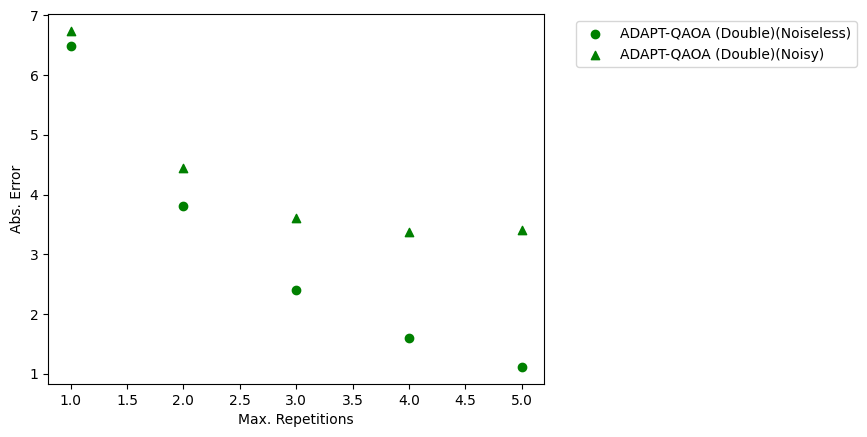

In [47]:
plt.scatter(repetitions_list, avg_aqaoa_double_error_noiseless, color = 'g', marker = 'o', label = 'ADAPT-QAOA (Double)(Noiseless)')
plt.scatter(repetitions_list, avg_aqaoa_double_error_noisy, color = 'g', marker = '^', label = 'ADAPT-QAOA (Double)(Noisy)')

plt.xlabel("Max. Repetitions")
plt.ylabel("Abs. Error")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### DC-QAOA

In [28]:
dcqaoa_noiseless_optimal_cost = []
optimal_ansatz_dcqaoa = []

for reps in repetitions_list:
    print(f"Solving for Reps {reps}...")
    dcqaoa_noiseless_optimal_cost.append([])
    optimal_ansatz_dcqaoa.append([])
    for idx, hamiltonian in enumerate(graph_hamiltonians):
        dcqaoa = DCQAOA( hamiltonian, num_layers = reps, cd_hamiltonian_type = ['Y', 'XY', 'YX'])
        dcqaoa.run()
        dcqaoa_noiseless_optimal_cost[-1].append(dcqaoa.optimal_value)
        optimal_ansatz_dcqaoa[-1].append(dcqaoa.ansatz.copy().assign_parameters(dcqaoa.optimal_parameters))

Solving for Reps 1...
Solving for Reps 2...
Solving for Reps 3...
Solving for Reps 4...
Solving for Reps 5...


In [29]:
avg_dcqaoa_noiseless_optimal_cost = []
for optimal_cost_arr in dcqaoa_noiseless_optimal_cost:
    avg_dcqaoa_noiseless_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_dcqaoa_error_noiseless = [np.abs(avg_brute_optimal_cost - d_opt) for d_opt in avg_dcqaoa_noiseless_optimal_cost]

In [30]:
dcqaoa_noisy_optimal_cost = []

for ansatz_arr in optimal_ansatz_dcqaoa:
    dcqaoa_noisy_optimal_cost.append([])
    for ansatz, hamiltonian in zip(ansatz_arr, graph_hamiltonians):
        transpiled_ansatz = pm.run(ansatz)
        mapped_hamiltonian = hamiltonian.apply_layout(layout = transpiled_ansatz.layout)
        cost = estimator.run([(transpiled_ansatz, mapped_hamiltonian)]).result()[0].data.evs
        dcqaoa_noisy_optimal_cost[-1].append(cost)

In [31]:
avg_dcqaoa_noisy_optimal_cost = []
for optimal_cost_arr in dcqaoa_noisy_optimal_cost:
    avg_dcqaoa_noisy_optimal_cost.append(sum(optimal_cost_arr)/num_instances)

avg_dcqaoa_error_noisy = [np.abs(avg_brute_optimal_cost - d_opt) for d_opt in avg_dcqaoa_noisy_optimal_cost]

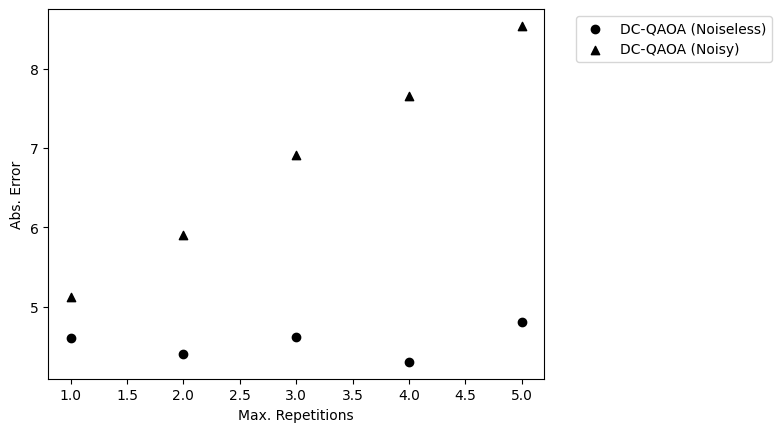

In [48]:
plt.scatter(repetitions_list, avg_dcqaoa_error_noiseless, color = 'k', marker = 'o', label = 'DC-QAOA (Noiseless)')
plt.scatter(repetitions_list, avg_dcqaoa_error_noisy, color = 'k', marker = '^', label = 'DC-QAOA (Noisy)')

plt.xlabel("Max. Repetitions")
plt.ylabel("Abs. Error")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Analysing the effect of noise on the algorithms

We saw that in the presence of noise, the performance of all the algorithms deteriorated as expected. Moreover, as the number of layers is increased, the effect of noise is exaggerated. Again, this is something expected as more gates will imply a larger error. Now, we will quantitatively analyze how much the noise has affected the optimal energies. To do that, the measure we will use is the absolute difference between the averages of noiseless and noisy optimals. We call this the error difference.

In [33]:
error_diff_vqe = [ns - nl for ns, nl in zip(avg_vqe_noisy_optimal_cost, avg_vqe_noiseless_optimal_cost)]
error_diff_qaoa = [ns - nl for ns, nl in zip(avg_qaoa_noisy_optimal_cost, avg_qaoa_noiseless_optimal_cost)]
error_diff_aqaoa_single = [ns - nl for ns, nl in zip(avg_aqaoa_single_noisy_optimal_cost, avg_aqaoa_single_noiseless_optimal_cost)]
error_diff_aqaoa_double = [ns - nl for ns, nl in zip(avg_aqaoa_double_noisy_optimal_cost, avg_aqaoa_double_noiseless_optimal_cost)]
error_diff_dcqaoa = [ns - nl for ns, nl in zip(avg_dcqaoa_noisy_optimal_cost, avg_dcqaoa_noiseless_optimal_cost)]

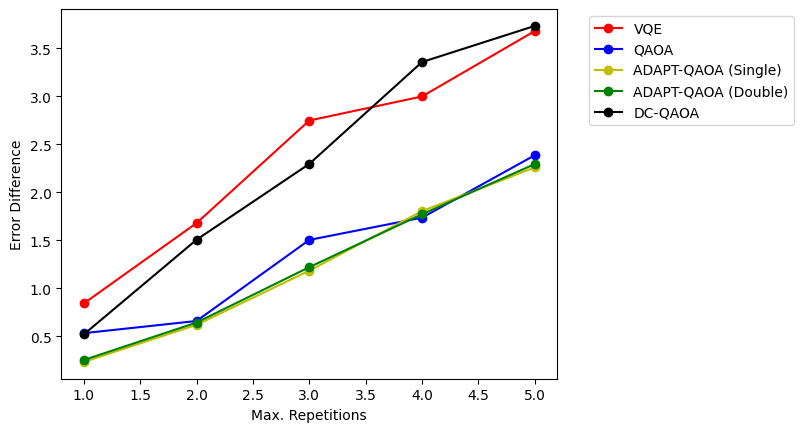

In [49]:
plt.plot(repetitions_list, error_diff_vqe, color = 'r', marker = 'o', label = 'VQE')
plt.plot(repetitions_list, error_diff_qaoa, color = 'b', marker = 'o', label = 'QAOA')
plt.plot(repetitions_list, error_diff_aqaoa_single, color = 'y', marker = 'o', label = 'ADAPT-QAOA (Single)')
plt.plot(repetitions_list, error_diff_aqaoa_double, color = 'g', marker = 'o', label = 'ADAPT-QAOA (Double)')
plt.plot(repetitions_list, error_diff_dcqaoa, color = 'k', marker = 'o', label = 'DC-QAOA')

plt.xlabel("Max. Repetitions")
plt.ylabel("Error Difference")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Of all the variational algorithms considered, ADAPT-QAOA with both single and double mixer types is the least affected by the noise in the backend. In contrast, the effect of noise on VQE is the largest. A possible justification is that the number of gates or the depth of the VQE circuit is larger than the others. To verify this claim, let us check the average number of gates and the average depth if the circuit for each algorithm.

In [38]:
avg_vqe_num_gates = [
    sum([sum(ansatz.decompose(reps = 3).count_ops().values()) for ansatz in ansatz_arr])/num_instances for ansatz_arr in optimal_ansatz_vqe
]
avg_qaoa_num_gates = [
    sum([sum(ansatz.decompose(reps = 3).count_ops().values()) for ansatz in ansatz_arr])/num_instances for ansatz_arr in optimal_ansatz_qaoa
]
avg_aqaoa_single_num_gates = [
    sum([sum(ansatz.decompose(reps = 3).count_ops().values()) for ansatz in ansatz_arr])/num_instances for ansatz_arr in optimal_ansatz_aqaoa_single
]
avg_aqaoa_double_num_gates = [
    sum([sum(ansatz.decompose(reps = 3).count_ops().values()) for ansatz in ansatz_arr])/num_instances for ansatz_arr in optimal_ansatz_aqaoa_double
]
avg_dcqaoa_num_gates = [
    sum([sum(ansatz.decompose(reps = 3).count_ops().values()) for ansatz in ansatz_arr])/num_instances for ansatz_arr in optimal_ansatz_dcqaoa
]

In [39]:
avg_vqe_depth = [
    sum([ansatz.decompose(reps = 3).depth() for ansatz in ansatz_arr])/num_instances for ansatz_arr in optimal_ansatz_vqe
]
avg_qaoa_depth = [
    sum([ansatz.decompose(reps = 3).depth() for ansatz in ansatz_arr])/num_instances for ansatz_arr in optimal_ansatz_qaoa
]
avg_aqaoa_single_depth = [
    sum([ansatz.decompose(reps = 3).depth() for ansatz in ansatz_arr])/num_instances for ansatz_arr in optimal_ansatz_aqaoa_single
]
avg_aqaoa_double_depth = [
    sum([ansatz.decompose(reps = 3).depth() for ansatz in ansatz_arr])/num_instances for ansatz_arr in optimal_ansatz_aqaoa_double
]
avg_dcqaoa_depth = [
    sum([ansatz.decompose(reps = 3).depth() for ansatz in ansatz_arr])/num_instances for ansatz_arr in optimal_ansatz_dcqaoa
]

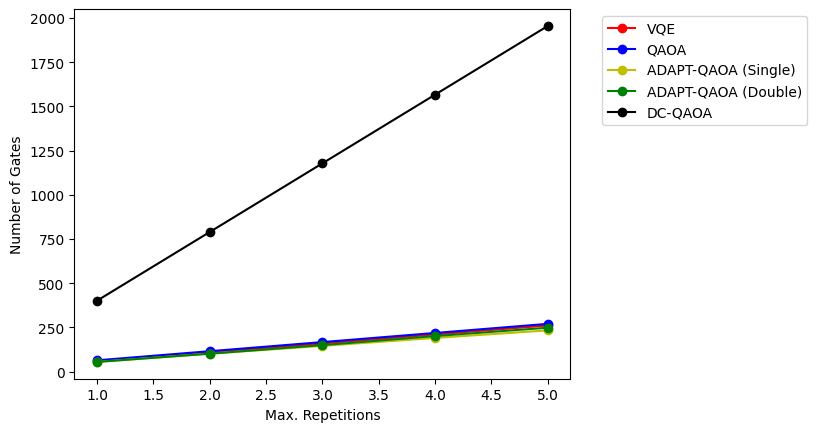

In [40]:
plt.plot(repetitions_list, avg_vqe_num_gates, color = 'r', marker = 'o', label = 'VQE')
plt.plot(repetitions_list, avg_qaoa_num_gates, color = 'b', marker = 'o', label = 'QAOA')
plt.plot(repetitions_list, avg_aqaoa_single_num_gates, color = 'y', marker = 'o', label = 'ADAPT-QAOA (Single)')
plt.plot(repetitions_list, avg_aqaoa_double_num_gates, color = 'g', marker = 'o', label = 'ADAPT-QAOA (Double)')
plt.plot(repetitions_list, avg_dcqaoa_num_gates, color = 'k', marker = 'o', label = 'DC-QAOA')

plt.xlabel("Max. Repetitions")
plt.ylabel("Avg. Number of Gates")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

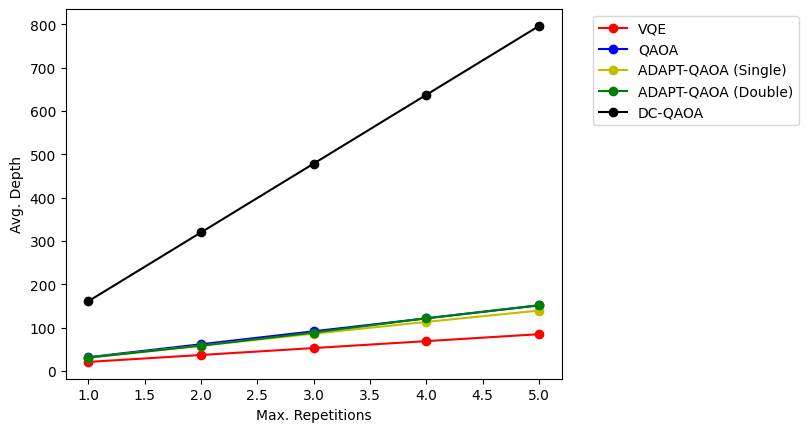

In [41]:
plt.plot(repetitions_list, avg_vqe_depth, color = 'r', marker = 'o', label = 'VQE')
plt.plot(repetitions_list, avg_qaoa_depth, color = 'b', marker = 'o', label = 'QAOA')
plt.plot(repetitions_list, avg_aqaoa_single_depth, color = 'y', marker = 'o', label = 'ADAPT-QAOA (Single)')
plt.plot(repetitions_list, avg_aqaoa_double_depth, color = 'g', marker = 'o', label = 'ADAPT-QAOA (Double)')
plt.plot(repetitions_list, avg_dcqaoa_depth, color = 'k', marker = 'o', label = 'DC-QAOA')

plt.xlabel("Max. Repetitions")
plt.ylabel("Avg. Depth")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

But we can clearly see that the average number of gates for the VQE circuit is at par with the other algorithms except DC-QAOA, and the average depth of the VQE circuit is the least among the variational algorithms. So, clearly, the harsh effect of noise on VQE is not due to a large number of gates or large depth.

Another possible cause for high susceptibility to noise could be the number of two-qubit gates in the ansatz circuit. To verify if that is the case in this scenario, let us calculate the average number of two-qubit gates in the ansatz for each algorithm.

In [42]:
avg_vqe_num_2q_gates = [
    sum([sum([1 for _, qargs, _ in ansatz.decompose(reps = 3).data if len(qargs) == 2]) for ansatz in ansatz_arr])/num_instances for ansatz_arr in optimal_ansatz_vqe
]
avg_qaoa_num_2q_gates = [
    sum([sum([1 for _, qargs, _ in ansatz.decompose(reps = 3).data if len(qargs) == 2]) for ansatz in ansatz_arr])/num_instances for ansatz_arr in optimal_ansatz_qaoa
]
avg_aqaoa_single_num_2q_gates = [
    sum([sum([1 for _, qargs, _ in ansatz.decompose(reps = 3).data if len(qargs) == 2]) for ansatz in ansatz_arr])/num_instances for ansatz_arr in optimal_ansatz_aqaoa_single
]
avg_aqaoa_double_num_2q_gates = [
    sum([sum([1 for _, qargs, _ in ansatz.decompose(reps = 3).data if len(qargs) == 2]) for ansatz in ansatz_arr])/num_instances for ansatz_arr in optimal_ansatz_aqaoa_double
]
avg_dcqaoa_num_2q_gates = [
    sum([sum([1 for _, qargs, _ in ansatz.decompose(reps = 3).data if len(qargs) == 2]) for ansatz in ansatz_arr])/num_instances for ansatz_arr in optimal_ansatz_dcqaoa
]

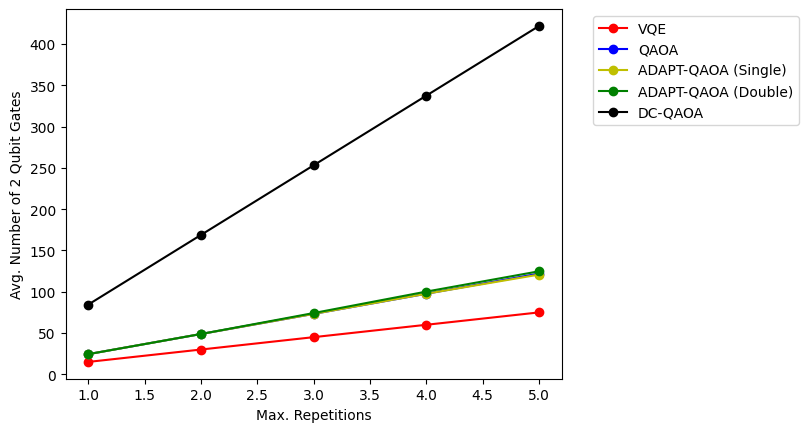

In [43]:
plt.plot(repetitions_list, avg_vqe_num_2q_gates, color = 'r', marker = 'o', label = 'VQE')
plt.plot(repetitions_list, avg_qaoa_num_2q_gates, color = 'b', marker = 'o', label = 'QAOA')
plt.plot(repetitions_list, avg_aqaoa_single_num_2q_gates, color = 'y', marker = 'o', label = 'ADAPT-QAOA (Single)')
plt.plot(repetitions_list, avg_aqaoa_double_num_2q_gates, color = 'g', marker = 'o', label = 'ADAPT-QAOA (Double)')
plt.plot(repetitions_list, avg_dcqaoa_num_2q_gates, color = 'k', marker = 'o', label = 'DC-QAOA')

plt.xlabel("Max. Repetitions")
plt.ylabel("Avg. Number of 2 Qubit Gates")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

But again, VQE has the least average number of two-qubit gates among the algorithms we have considered. So, the number of two-qubit gates is also not the cause of VQE's high susceptibility to noise. 

Now, this is an interesting situation. While it is common to assume that large number of gates, large depth or large number of two-qubit gates pronounce the effect of noise, these do not seem to be the case of VQE. So, __an interesting line of further study would be to investigate if VQE is inherently susceptible to noise and what property of VQE makes it so__.

In the next notebook, we will see how we can use error mitigation techniques, like Zero Noise Extrapolation, to mitigate the effects of noise and to what extent would we be able to mitigate noise.